### Update Nov. 09
#### Feature Generation
- We add **5** new features, this leads to a **slightly ROC-AUC improvement**.
    - Logistic regression, ROC-AUC: 0.8371 to **0.8518**.
    - SVM, ROC-AUC: **0.7410** to 0.7372.
    - Random forest, ROC-AUC: 0.8555 to **0.8627**.

### 0: Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

### 1: Data Preprocessing

In [2]:
# read data
df = pd.read_csv('Dataset_model_building/songs.csv')
df.shape
print('Without any processing: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# remove duplicates
df = df.drop_duplicates(['track', 'artist'])
print('\nAfter removing duplicates: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# drop missing values
df = df.dropna()
print('\nAfter dropping missing values: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# deal with missing value of 'available_markets'
df['available_markets'] = df['available_markets'].replace(0, np.nan)
df['available_markets'] = df['available_markets'].replace(np.nan, df.available_markets.median())
print('\nAfter imputation: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

Without any processing: (10809, 24)
Number of tracks in Top200: 7700
Number of tracks in Non-Top200: 3109

After removing duplicates: (3779, 24)
Number of tracks in Top200: 764
Number of tracks in Non-Top200: 3015

After dropping missing values: (3768, 24)
Number of tracks in Top200: 763
Number of tracks in Non-Top200: 3005

After imputation: (3768, 24)
Number of tracks in Top200: 763
Number of tracks in Non-Top200: 3005


### 2: Simple EDA
skip

### 3: Model Building

In [3]:
# shuffle
songs = df.sample(frac=1, random_state=56)
X = songs.copy().drop(['album', 'track', 'artist', 'y'], axis=1)
y = songs.y

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=56)
print(X_train.shape)
print(X_test.shape)
print('Baseline model accuracy: {}'.format((y_test==0).sum()/y_test.shape[0]))

# standarize data
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

(2637, 20)
(1131, 20)
Baseline model accuracy: 0.7975243147656941


In [4]:
def draw_roc_curve(y, x, model, flag=1):
    """ function for ROC curve plotting """
    
    # import library
    from sklearn.metrics import roc_auc_score, roc_curve

    # ROC
    y_score = model.predict_proba(x)[:,1]
    fpr, tpr, thr = roc_curve(y, y_score)

    # ROC-AUC
    rocauc = roc_auc_score(y, y_score, average='micro')
    
    # plot curve
    if flag:
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' %rocauc)
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title('ROC Curve')
        plt.margins(.02)
        plt.legend()
        plt.grid()
        plt.show()
    
    return rocauc

### 3.1 Linear model: Logistic Regression

Best parameters: {'C': 1.0}
Best cross-validation AUC: 0.8128


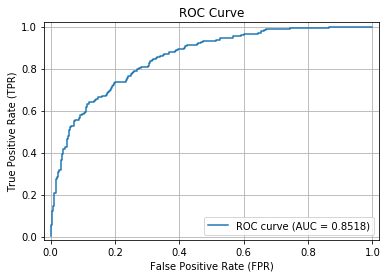

In [5]:
# Logistic Regression
# specify hyperparameters
param_grid = {'C': np.logspace(-4, 4, 9)}

# initialize grid search
grid_search = GridSearchCV(LogisticRegression(random_state=56), param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5, n_jobs=-1)

# validate model
grid_search.fit(X_train_sc, y_train)

# get the best model
logreg = grid_search
print("Best parameters: {}".format(logreg.best_params_))
print("Best cross-validation AUC: {:.4f}".format(logreg.best_score_))

# ROC-AUC
rocauc = draw_roc_curve(y_test, X_test_sc, logreg, flag=1)

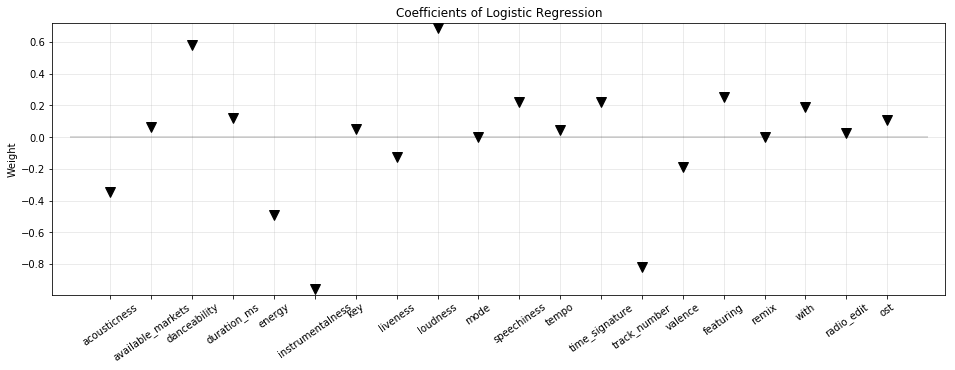

In [6]:
# plot coefficients
plt.figure(figsize=(16,5))
plt.hlines(0, -1, len(X.columns), alpha=.2)
plt.plot(logreg.best_estimator_.coef_[0], 'kv', ms=10)
plt.title('Coefficients of Logistic Regression')
plt.ylabel('Weight')
plt.xticks(np.arange(len(X.columns)), X.columns.tolist(), rotation=35)
plt.margins(.02)
plt.grid(alpha=0.3)
plt.show()

### 3.2 Nonlinear model: SVM with kernel

Best parameters: {'C': 0.10000000000000001, 'gamma': 0.5}
Best cross-validation AUC: 0.7366


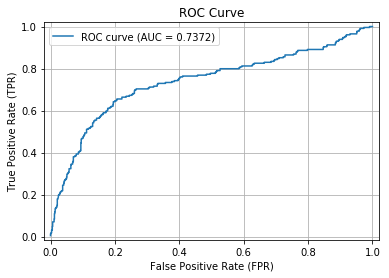

In [7]:
# SVM
# build and validate model
param_grid = {'C': np.logspace(-1, 1, 3), 'gamma': [.5, 1, 2, 3]}

# initialize grid search
grid_search = GridSearchCV(SVC(kernel='rbf', probability=True),
                           param_grid =param_grid, cv=5,
                           scoring='roc_auc',
                           n_jobs=-1, error_score=0)

# fit and validate model
grid_search.fit(X_train_sc, y_train)

# get the best model
svm = grid_search
print("Best parameters: {}".format(svm.best_params_))
print("Best cross-validation AUC: {:.4f}".format(svm.best_score_))

# ROC-AUC
rocauc = draw_roc_curve(y_test, X_test_sc, svm, flag=1)

### 3.3 Ensemble method: Random Forest

Best parameters: {'max_depth': 9, 'n_estimators': 140}
Best cross-validation AUC: 0.8490


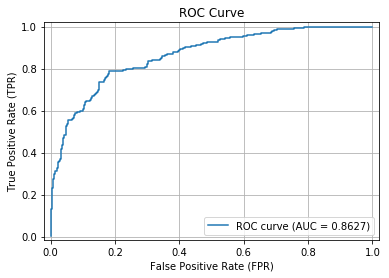

In [8]:
# Random Forest
# build and validate model
param_grid = {'n_estimators': np.arange(130,180,10),
              'max_depth': np.arange(5,14,2)}

# initialize the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5, n_jobs=-1)

# fit and validate model
grid_search.fit(X_train, y_train)

# get the best model
ranfor = grid_search
print("Best parameters: {}".format(ranfor.best_params_))
print("Best cross-validation AUC: {:.4f}".format(ranfor.best_score_))

# ROC-AUC
rocauc = draw_roc_curve(y_test, X_test, ranfor, flag=1)

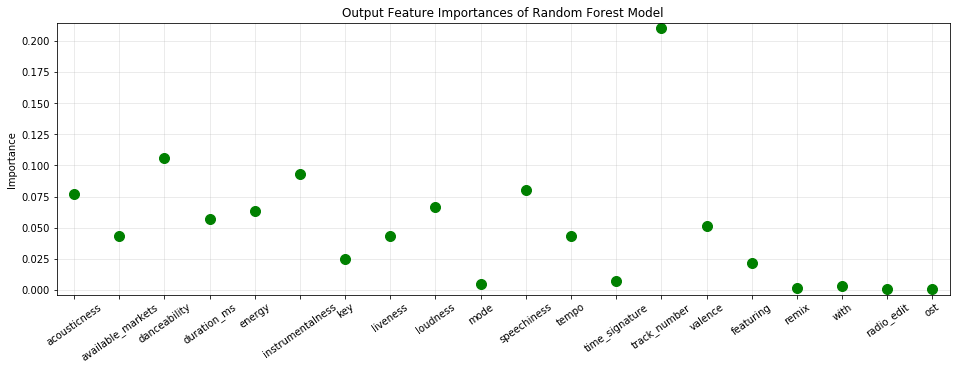

In [9]:
# Feature importances
plt.figure(figsize=(16,5))
plt.plot(grid_search.best_estimator_.feature_importances_, 'go', ms=10)
plt.ylabel('Importance')
plt.title('Output Feature Importances of Random Forest Model')
plt.xticks(np.arange(len(X.columns)), X.columns.tolist(), rotation=35)
plt.margins(.02)
plt.grid(alpha=.3)
plt.show()

### 4: Performance Evaluation: ROC

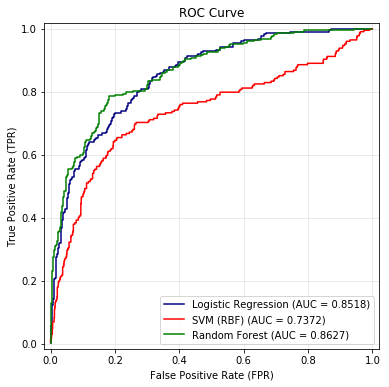

In [10]:
# figure size
plt.figure(figsize=(6, 6))

# Logistic regression
fpr, tpr, thr = roc_curve(y_test, logreg.predict_proba(X_test_sc)[:,1])
rocauc = roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:,1], average='micro')
plt.plot(fpr, tpr, color='navy', label='Logistic Regression (AUC = %0.4f)' %rocauc)

# SVM
fpr, tpr, thr = roc_curve(y_test, svm.predict_proba(X_test_sc)[:,1])
rocauc = roc_auc_score(y_test, svm.predict_proba(X_test_sc)[:,1], average='micro')
plt.plot(fpr, tpr, color='red', label='SVM (RBF) (AUC = %0.4f)' %rocauc)

# Random forest
fpr, tpr, thr = roc_curve(y_test, ranfor.predict_proba(X_test)[:,1])
rocauc = roc_auc_score(y_test, ranfor.predict_proba(X_test)[:,1], average='micro')
plt.plot(fpr, tpr, color='green', label='Random Forest (AUC = %0.4f)' %rocauc)

# figure properties
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title('ROC Curve')
plt.margins(.02)
plt.legend()
plt.grid(alpha=.3)
plt.show()